In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from LP import LP
from DeepLP import DeepLP
from DeepLP_RBF import DeepLP_RBF
from DeepLP_WeightedRBF import DeepLP_WeightedRBF
from utils import *

# Data Preparation

In [2]:
# get labels, features and weights
LX, Ly, UX, Uy, Uy_sol = get_iris_data()
features = np.vstack((LX,UX))
true_labels = np.hstack((Ly,Uy_sol))
weights = rbf_kernel(features)
num_labeled = len(Ly)
num_unlabeled = len(Uy)
num_nodes = num_labeled+num_unlabeled
graph = (weights > 0).astype(int)

In [3]:
# prepare features for NN
LY = np.tile(Ly,(Ly.shape[0],1))
np.fill_diagonal(LY, 0.5)
UY = np.tile(Uy,(Ly.shape[0],1))

masked_ = np.hstack((np.identity(LY.shape[0]),np.zeros((Ly.shape[0],Uy.shape[0]))))

In [4]:
true_labeled = np.array([1] * LY.shape[0] + [0] * Uy.shape[0]).reshape(1,100)

In [5]:
unlabeled_test = np.hstack((np.zeros(LY.shape[0]),np.ones((Uy.shape[0])))).reshape(1,100)
test_data = {
    'X': np.hstack((Ly,Uy)).reshape(1,100),
    'y': np.tile(true_labels,(Ly.shape[0],1))[1:2],
    'unlabeled': unlabeled_test,
    'labeled': (1 - unlabeled_test).reshape(1,100),
    'true_labeled': true_labeled,
    'masked':masked_[0:1]
}

In [6]:
unlabeled_ = np.hstack((np.identity(LY.shape[0]),np.ones((Ly.shape[0],Uy.shape[0]))))
data = {
    'X':np.hstack((LY, UY)),
    'y':np.reshape(true_labels,(1,len(true_labels))),
    'unlabeled':unlabeled_,
    'labeled':1-unlabeled_,
    'true_labeled': true_labeled,
    'masked':masked_
}

# Label Propagation

In [9]:
lp = LP()
Uy_lp = np.rint(lp.closed(features,Ly))
Uy_lp_iter = np.rint(lp.iter_(features,Ly,Uy,1000))

In [10]:
print("[Accuracy] Closed solution:", accuracy(Uy_sol, Uy_lp), " Iter Solution:", accuracy(Uy_sol, Uy_lp_iter))
print("[RMSE] Closed solution", rmse(Uy_sol, Uy_lp), " Iter solution", rmse(Uy_sol, Uy_lp))

[Accuracy] Closed solution: 0.8  Iter Solution: 0.8
[RMSE] Closed solution 0.2  Iter solution 0.2


In [11]:
# for iter_ in [1,2,3,4,5,10,100,1000]:
#     print(iter_)
#     Uy_lp_iter = np.rint(lp.iter_(features,Ly,Uy,iter_))
#     print("Objective:", objective(Ly,np.rint(Uy_lp_iter),weights))
#     print("Accuracy:", accuracy(Uy_sol,Uy_lp_iter))
#     print("RMSE:", rmse(Uy_sol,Uy_lp_iter))

# DeepLP

In [12]:
sess = tf.Session()
dlp = DeepLP(10, num_nodes, weights, 1, sess)

In [13]:
pred_dlp = dlp.labelprop(test_data)
Uy_dlp = np.rint(pred_dlp[:,num_labeled:]).reshape(num_unlabeled)

In [14]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp))
print("RMSE:", rmse(Uy_sol,Uy_dlp))
print("Objective:", objective(Ly,Uy_dlp,dlp.get_value(dlp.W)))

Accuracy: 0.8
RMSE: 0.2
Objective: 1271.07189292


# DeepLP_RBF

In [33]:
sess = tf.Session()
dlp_rbf = DeepLP_RBF(10, num_nodes, features, graph, np.var(features), 0.01, sess)

In [34]:
pred_dlp_rbf = dlp_rbf.labelprop(test_data)
Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

In [35]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_value(dlp_rbf.W)))

Accuracy: 0.8
RMSE: 0.2
Objective: 1271.07191023


In [42]:
dlp_rbf.train(data,100)

epoch: -1 labeled loss: 0.292588 unlabeled loss: 0.228682 accuracy: 0.646
epoch: 0 labeled loss: 0.292166 unlabeled loss: 0.228344 accuracy: 0.652
sigma: 3.46386
epoch: 10 labeled loss: 0.286985 unlabeled loss: 0.223562 accuracy: 0.706
epoch: 20 labeled loss: 0.283887 unlabeled loss: 0.218972 accuracy: 0.742
epoch: 30 labeled loss: 0.283887 unlabeled loss: 0.218982 accuracy: 0.742
epoch: 40 labeled loss: 0.283887 unlabeled loss: 0.218963 accuracy: 0.742
epoch: 50 labeled loss: 0.283887 unlabeled loss: 0.218964 accuracy: 0.742
epoch: 60 labeled loss: 0.283887 unlabeled loss: 0.218964 accuracy: 0.742
epoch: 70 labeled loss: 0.283887 unlabeled loss: 0.218964 accuracy: 0.742
epoch: 80 labeled loss: 0.283887 unlabeled loss: 0.218964 accuracy: 0.742
epoch: 90 labeled loss: 0.283887 unlabeled loss: 0.218964 accuracy: 0.742


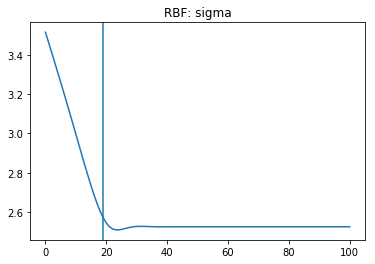

In [131]:
plt.plot(dlp_rbf.sigmas)
plt.title("RBF: sigma")
plt.axvline(x=19)
plt.show()

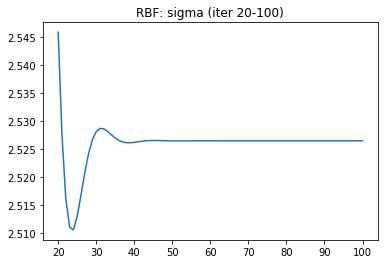

In [132]:
plt.plot(range(20,100+1),dlp_rbf.sigmas[20:])
plt.title("RBF: sigma (iter 20-100)")
plt.show()

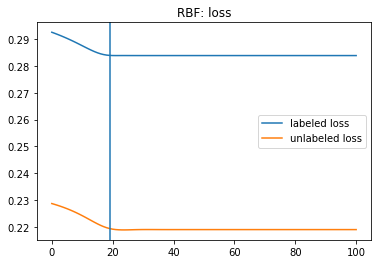

In [133]:
plt.plot(dlp_rbf.labeled_losses,label="labeled loss")
plt.plot(dlp_rbf.unlabeled_losses,label="unlabeled loss")
plt.title("RBF: loss")
plt.legend()
plt.axvline(x=19)
plt.show()

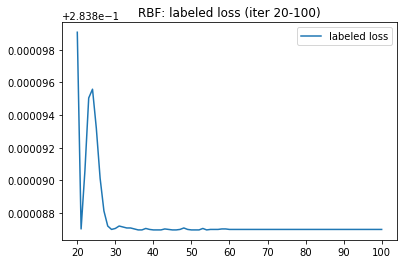

In [134]:
plt.plot(range(20,100+1),dlp_rbf.labeled_losses[20:],label="labeled loss")
# plt.plot(dlp_rbf.unlabeled_losses,label="unlabeled loss")
plt.title("RBF: labeled loss (iter 20-100)")
plt.legend()
plt.show()

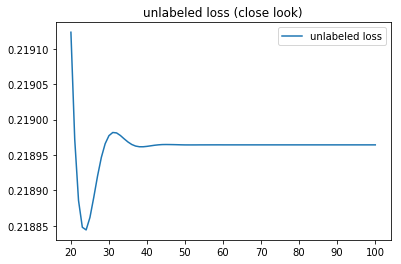

In [127]:
# plt.plot(range(20,100+1),dlp_rbf.labeled_losses[20:],label="labeled loss")
plt.plot(range(20,100+1),dlp_rbf.unlabeled_losses[20:],label="unlabeled loss")
plt.title("RBF: unlabeled loss (iter 20-100)")
plt.legend()
plt.show()

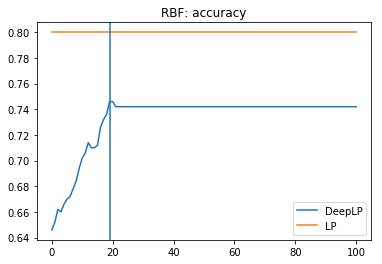

In [135]:
plt.plot(dlp_rbf.accuracies,label="DeepLP")
plt.plot([accuracy(Uy_sol,Uy_dlp_rbf)] * len(dlp_rbf.accuracies),label="LP")
plt.title("RBF: accuracy")
plt.axvline(x=19)
plt.legend()
plt.show()

# DeepLP_WeightedRBF

In [87]:
sess = tf.Session()
dlp_wrbf = DeepLP_WeightedRBF(10, num_nodes, features, graph, np.var(features), 0.01, sess)

In [88]:
pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)

In [89]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_wrbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_wrbf))
print("Objective:", objective(Ly,Uy_dlp_wrbf,dlp_wrbf.get_value(dlp_wrbf.W)))

Accuracy: 0.8
RMSE: 0.2
Objective: 1271.07191023


In [91]:
dlp_wrbf.train(data,200)

epoch: -1 labeled loss: 0.292588 unlabeled loss: 0.228682 accuracy: 0.646
epoch: 0 labeled loss: 0.289355 unlabeled loss: 0.227948 accuracy: 0.676
theta: [ 0.95002997  0.95007849  1.05001521  1.05000758]
epoch: 10 labeled loss: 0.266078 unlabeled loss: 0.221925 accuracy: 0.738
epoch: 20 labeled loss: 0.26286 unlabeled loss: 0.222575 accuracy: 0.75
epoch: 30 labeled loss: 0.261301 unlabeled loss: 0.222782 accuracy: 0.75
epoch: 40 labeled loss: 0.259534 unlabeled loss: 0.222995 accuracy: 0.738
epoch: 50 labeled loss: 0.25729 unlabeled loss: 0.223288 accuracy: 0.728
epoch: 60 labeled loss: 0.254676 unlabeled loss: 0.223663 accuracy: 0.726
epoch: 70 labeled loss: 0.252027 unlabeled loss: 0.224083 accuracy: 0.714
epoch: 80 labeled loss: 0.249854 unlabeled loss: 0.22447 accuracy: 0.708
epoch: 90 labeled loss: 0.248538 unlabeled loss: 0.22474 accuracy: 0.706
epoch: 100 labeled loss: 0.247972 unlabeled loss: 0.224872 accuracy: 0.696
theta: [  3.44411666e-10   4.93649388e-09   2.04139143e-01   

In [107]:
argmax = np.argmax(dlp_wrbf.accuracies)

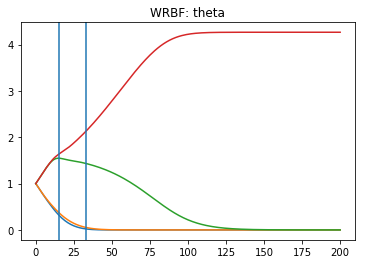

In [136]:
plt.plot(dlp_wrbf.thetas)
plt.title("WRBF: theta")
plt.axvline(x=argmax)
plt.axvline(x=33)
plt.show()

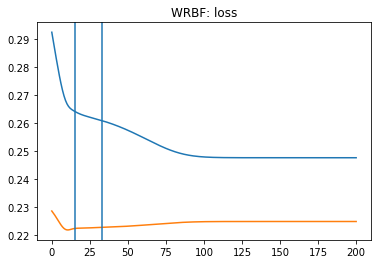

In [137]:
plt.plot(dlp_wrbf.labeled_losses)
plt.plot(dlp_wrbf.unlabeled_losses)
plt.title("WRBF: loss")
plt.axvline(x=argmax)
plt.axvline(x=33)
plt.show()

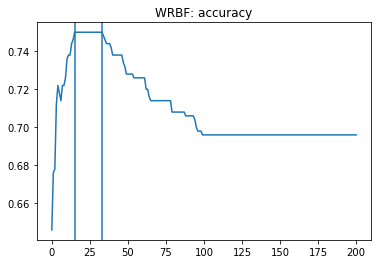

In [139]:
plt.plot(dlp_wrbf.accuracies)
plt.title("WRBF: accuracy")
plt.axvline(x=argmax)
plt.axvline(x=33)
plt.show()

In [119]:
dlp_wrbf.accuracies[33]

0.75

In [ ]:
# accuracies = []
# rmses = []
# objectives = []
# for sigma_ in sorted(sigmas):
#     sess = tf.Session()
#     dlp_rbf = DeepLP_RBF(10, num_nodes, features, graph, sigma_, 0.1, sess)
#     pred_dlp_rbf = dlp_rbf.labelprop(test_data)
#     Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)
#     print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
#     print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
#     print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_value(dlp_rbf.W)))
    
#     accuracies.append(accuracy)
#     rmses.append(rmse)
#     objectives.append(objective)
#     sess.close()
